In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from scipy import stats
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_absolute_percentage_error



# Load data

In [2]:
df = pd.read_csv('ggsn_thp.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616 entries, 0 to 615
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   week       616 non-null    int64  
 1   area       616 non-null    object 
 2   ne_thp     616 non-null    float64
 3   volte_vol  616 non-null    float64
 4   rab_user   616 non-null    float64
 5   ggsn       616 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 29.0+ KB


In [3]:
col_week = 'week'
col_area = 'area'
col_nethp = 'ne_thp'
col_volte = 'volte_vol'
col_rabuser = 'rab_user'
col_ggsn = 'ggsn'

col_date = 'date'

In [4]:
df.head()

,week,area,ne_thp,volte_vol,rab_user,ggsn
0,202150,Valparaiso,646.125895,308.484067,2300.921160,229.489611
1,202150,Luang Prabang,648.795419,218.974793,1619.360608,293.011472
2,202150,Chefchaouen,503.692732,412.065085,1733.568785,553.277913
3,202150,Hoi An,479.543186,135.423613,1300.605689,533.289586
4,202150,Antananarivo,423.156395,101.727074,1471.244589,441.462850


In [5]:
df.describe()

,week,ne_thp,volte_vol,rab_user,ggsn
count,616.000000,616.000000,616.000000,616.000000,616.000000
mean,202116.821429,450.702528,234.333467,1567.897937,420.535207
std,27.016055,156.948624,105.187460,511.977004,243.450670
min,202047.000000,64.977835,59.535763,572.206349,63.718254
25%,202107.750000,357.564693,132.889311,1249.448716,232.274627
50%,202121.500000,477.905343,249.200186,1616.140916,407.225813
75%,202136.000000,574.377243,304.286910,1840.411642,516.921587
max,202150.000000,713.875255,441.108184,2689.725152,1655.643375


In [6]:
df.drop(columns=df.describe().columns).describe()

,area
count,616
unique,11
top,Valparaiso
freq,56


# Preprocess

## Basic preprocessing

In [7]:
df[col_week] = df[col_week].astype(str)
df[col_date] = pd.to_datetime(df[col_week] + '0', format='%Y%W%w')
df = df.drop(columns=col_week)
df.head()

,area,ne_thp,volte_vol,rab_user,ggsn,date
0,Valparaiso,646.125895,308.484067,2300.921160,229.489611,2021-12-19
1,Luang Prabang,648.795419,218.974793,1619.360608,293.011472,2021-12-19
2,Chefchaouen,503.692732,412.065085,1733.568785,553.277913,2021-12-19
3,Hoi An,479.543186,135.423613,1300.605689,533.289586,2021-12-19
4,Antananarivo,423.156395,101.727074,1471.244589,441.462850,2021-12-19


## Train test split

In [8]:
datefirst = df[col_date].min()
datelast = df[col_date].max()
print('First date:', datefirst)
print('Last date:', datelast)

datesplit = datefirst + (datelast - datefirst) * 0.8
print('Datesplit:', datesplit)

dftrain = df[df[col_date] <= datesplit]
dftest = df[df[col_date] > datesplit]
print('dftrain shape:', dftrain.shape)
print('dftest shape:', dftest.shape)

First date: 2020-11-29 00:00:00
Last date: 2021-12-19 00:00:00
Datesplit: 2021-10-03 00:00:00
dftrain shape: (506, 6)
dftest shape: (110, 6)


## Partition by area

In [9]:
dictdf = {}
for area, dfgroup in dftrain.groupby(col_area):
    dictdf[area] = dfgroup.copy().sort_values(col_date).reset_index(drop=True)
    
print('Length of dictdf:', len(dictdf))
area = df[col_area].sample(1).iat[0]
print('Sample:',area)
display(dictdf[area].head())
dfdisplay = []
for area in dictdf.keys():
    dfdisplay.append({
        'area': area,
        'nrow': dictdf[area].shape[0],
        'ncol': dictdf[area].shape[1],
        'firstdate': dictdf[area][col_date].min(),
        'lastdate': dictdf[area][col_date].max()
    })
display(pd.DataFrame(dfdisplay))

Length of dictdf: 11
Sample: Cuenca


,area,ne_thp,volte_vol,rab_user,ggsn,date
0,Cuenca,531.157961,370.272108,1180.708619,507.791502,2020-11-29
1,Cuenca,571.815974,398.594941,1252.105022,514.854077,2020-12-06
2,Cuenca,565.186145,393.827423,1334.344733,521.556847,2020-12-13
3,Cuenca,547.488612,379.484963,1123.739573,516.844712,2020-12-20
4,Cuenca,573.088872,397.978047,1201.899204,517.856389,2020-12-27


,area,nrow,ncol,firstdate,lastdate
0,Antananarivo,46,6,2020-11-29,2021-10-03
1,Asmara,46,6,2020-11-29,2021-10-03
2,Chefchaouen,46,6,2020-11-29,2021-10-03
3,Cuenca,46,6,2020-11-29,2021-10-03
4,Essaouira,46,6,2020-11-29,2021-10-03
5,Hoi An,46,6,2020-11-29,2021-10-03
6,Luang Prabang,46,6,2020-11-29,2021-10-03
7,Nafplio,46,6,2020-11-29,2021-10-03
8,Valletta,46,6,2020-11-29,2021-10-03
9,Valparaiso,46,6,2020-11-29,2021-10-03


## Impute missing date, if any

In [10]:
def impute_missing_date(dfarea, date_begin, date_end, column_date, cols, column_area, winsize=7, min_periods=1):
    # construct completed dates
    dates_complete = pd.date_range(date_begin, date_end, freq='W-Sun')
    dfdate = pd.DataFrame({
        col_date: dates_complete
    })

    # merge
    dfi = pd.merge(dfdate, dfarea, how='left', on=column_date)
    for c in cols:
        dfi.loc[dfi[c].isna(), c] = dfi[c]\
            .rolling(window=winsize, min_periods=min_periods)\
            .apply(np.nanmean)
    dfi[column_area] = dfi[column_area].fillna(dfi[column_area].dropna().iat[0])
    
    return dfi

dictdf_imp = {}

for area in dictdf.keys():
    dictdf_imp[area] = impute_missing_date(
        dfarea=dictdf[area],
        date_begin=datefirst,
        date_end=datesplit,
        column_date=col_date,
        cols=[col_ggsn, col_nethp, col_rabuser, col_volte],
        column_area=col_area
    )

print('Data shape after imputing missing dates:')
for area in dictdf_imp.keys():
    print(f'Data shape of {area}: {dictdf_imp[area].shape}, missing: {dictdf_imp[area].isna().sum().sum()}')
area = df[col_area].sample(1).iat[0]
print('Sample:',area)
display(dictdf_imp[area].head())

Data shape after imputing missing dates:
Data shape of Antananarivo: (48, 6), missing: 0
Data shape of Asmara: (48, 6), missing: 0
Data shape of Chefchaouen: (48, 6), missing: 0
Data shape of Cuenca: (48, 6), missing: 0
Data shape of Essaouira: (48, 6), missing: 0
Data shape of Hoi An: (48, 6), missing: 0
Data shape of Luang Prabang: (48, 6), missing: 0
Data shape of Nafplio: (48, 6), missing: 0
Data shape of Valletta: (48, 6), missing: 0
Data shape of Valparaiso: (48, 6), missing: 0
Data shape of Wilmington: (48, 6), missing: 0
Sample: Essaouira


,date,area,ne_thp,volte_vol,rab_user,ggsn
0,2020-11-29,Essaouira,259.049763,124.430368,587.373569,199.499443
1,2020-12-06,Essaouira,261.711627,125.739030,590.376544,201.647803
2,2020-12-13,Essaouira,276.021912,132.854021,638.830074,210.693615
3,2020-12-20,Essaouira,265.927968,127.127914,572.206349,201.972161
4,2020-12-27,Essaouira,265.263807,127.047511,580.730049,206.023062


## Outlier detection

In [11]:
def detect_outlier(xs, winsize=5, dispersion_factor = 2, verbose=False, pos=None):
    
    if pos is None:
        pos = 'center'
    
    if pos == 'center':
        center_idx = winsize // 2
        
        if (len(xs) < winsize):
            center_idx = len(xs) - int(np.ceil(winsize / 2))
    elif pos == 'last':
        center_idx = winsize - 1
    else:
        raise Exception('pos argument only accepts None, \'center\', or \'last\'')
    
    
    center = xs[center_idx]
    
    # Outlier method 1: window median
    med = np.nanmedian(xs)
    dist_to_med = center - med
    
    #avg = np.nanmean(xs)
    #dist_to_mean = center - avg

    iqr = np.percentile(xs, 75)- np.percentile(xs, 25)
    
    local_med_outlier = (np.abs(dist_to_med) > dispersion_factor * iqr)*1
    #local_mean_outlier = (np.abs(dist_to_mean) > dispersion_factor * iqr)*1
    
    bef = xs[:center_idx]
    aft = xs[center_idx:]
    
    # Outlier method 2: Median of points before center
    med_bef = np.nanmedian(bef)
    iqr_bef = np.percentile(bef, 75)- np.percentile(bef, 25)
    
    # Outlier method 3: Median of points after center
    med_aft = np.nanmedian(aft)
    iqr_aft = np.percentile(aft, 75)- np.percentile(aft, 25)
    
    bef_med_outlier = (np.abs(center - med_bef) > dispersion_factor * iqr_bef)*1
    aft_med_outlier = (np.abs(center - med_aft) > dispersion_factor * iqr_aft)*1
    
    outlier_score = np.mean([local_med_outlier, bef_med_outlier, aft_med_outlier])
                    
    if verbose:
        print(f'xs: {xs}')
        print(f'len(xs): {len(xs)}')
        print(f'center_idx: {center_idx}')
        print(f'med: {med}')
        print(f'dist_to_med: {dist_to_med}')
        print(f'iqr: {iqr}')
        print(f'med_bef: {med_bef}')
        print(f'iqr_bef: {iqr_bef}')
        print(f'med_aft: {med_aft}')
        print(f'iqr_aft: {iqr_aft}')
        print(f'local_med_outlier: {local_med_outlier}')
        print(f'bef_med_outlier: {bef_med_outlier}')
        print(f'aft_med_outlier: {aft_med_outlier}')
        print(f'outlier_score: {outlier_score}')
        print('')
        
    return(outlier_score)

In [12]:
winsize = 7

dictdf_out = {}
dfreport = []

for area in dictdf_imp.keys():
    dfo = dictdf_imp[area].copy()
    
    # on col_ggsn
    dfo[f'{col_ggsn}_outlier'] =  dfo[col_ggsn].rolling(window=winsize, center=True)\
            .apply(detect_outlier, raw=True, kwargs={'winsize': winsize,
                                                     'dispersion_factor': 1.5,
                                                     'verbose': False})
    dfo[f'{col_ggsn}_outlier'] = dfo[f'{col_ggsn}_outlier'].fillna(
        dfo[col_ggsn].rolling(window=winsize, center=False)\
            .apply(detect_outlier, raw=True, kwargs={'winsize': winsize,
                                                     'dispersion_factor': 1.5,
                                                     'verbose': False}))
    dfo[f'{col_ggsn}_outlier'] = dfo[f'{col_ggsn}_outlier'].fillna(
        dfo[col_ggsn].iloc[::-1].rolling(window=winsize, center=False)\
            .apply(detect_outlier, raw=True, kwargs={'winsize': winsize,
                                                     'dispersion_factor': 1.5,
                                                     'verbose': False})\
                .iloc[::-1])
    # Set default override flag to False
    dfo[f'{col_ggsn}_outlier_override'] = False
    
    # on col_nethp
    dfo[f'{col_nethp}_outlier'] =  dfo[col_nethp].rolling(window=winsize, center=True)\
            .apply(detect_outlier, raw=True, kwargs={'winsize': winsize,
                                                     'dispersion_factor': 1.5,
                                                     'verbose': False})
    dfo[f'{col_nethp}_outlier'] = dfo[f'{col_nethp}_outlier'].fillna(
        dfo[col_nethp].rolling(window=winsize, center=False)\
            .apply(detect_outlier, raw=True, kwargs={'winsize': winsize,
                                                     'dispersion_factor': 1.5,
                                                     'verbose': False}))
    dfo[f'{col_nethp}_outlier'] = dfo[f'{col_nethp}_outlier'].fillna(
        dfo[col_nethp].iloc[::-1].rolling(window=winsize, center=False)\
            .apply(detect_outlier, raw=True, kwargs={'winsize': winsize,
                                                     'dispersion_factor': 1.5,
                                                     'verbose': False})\
                .iloc[::-1])
    dfo[f'{col_nethp}_outlier_override'] = False

    # on col_rabuser
    dfo[f'{col_rabuser}_outlier'] =  dfo[col_rabuser].rolling(window=winsize, center=True)\
            .apply(detect_outlier, raw=True, kwargs={'winsize': winsize,
                                                     'dispersion_factor': 1.5,
                                                     'verbose': False})
    dfo[f'{col_rabuser}_outlier'] = dfo[f'{col_rabuser}_outlier'].fillna(
        dfo[col_rabuser].rolling(window=winsize, center=False)\
            .apply(detect_outlier, raw=True, kwargs={'winsize': winsize,
                                                     'dispersion_factor': 1.5,
                                                     'verbose': False}))
    dfo[f'{col_rabuser}_outlier'] = dfo[f'{col_rabuser}_outlier'].fillna(
        dfo[col_rabuser].iloc[::-1].rolling(window=winsize, center=False)\
            .apply(detect_outlier, raw=True, kwargs={'winsize': winsize,
                                                     'dispersion_factor': 1.5,
                                                     'verbose': False})\
                .iloc[::-1])
    dfo[f'{col_rabuser}_outlier_override'] = False

    # on col_volte
    dfo[f'{col_volte}_outlier'] =  dfo[col_volte].rolling(window=winsize, center=True)\
            .apply(detect_outlier, raw=True, kwargs={'winsize': winsize,
                                                     'dispersion_factor': 1.5,
                                                     'verbose': False})
    dfo[f'{col_volte}_outlier'] = dfo[f'{col_volte}_outlier'].fillna(
        dfo[col_volte].rolling(window=winsize, center=False)\
            .apply(detect_outlier, raw=True, kwargs={'winsize': winsize,
                                                     'dispersion_factor': 1.5,
                                                     'verbose': False}))
    dfo[f'{col_volte}_outlier'] = dfo[f'{col_volte}_outlier'].fillna(
        dfo[col_volte].iloc[::-1].rolling(window=winsize, center=False)\
            .apply(detect_outlier, raw=True, kwargs={'winsize': winsize,
                                                     'dispersion_factor': 1.5,
                                                     'verbose': False})\
                .iloc[::-1])
    dfo[f'{col_volte}_outlier_override'] = False
    
    dictdf_out[area] = dfo.copy()

    dfreport.append({
        'area': area,
        'nrow_bef': dictdf_imp[area].shape[0],
        'ncol_bef': dictdf_imp[area].shape[1],
        'nrow_af': dictdf_out[area].shape[0],
        'ncol_af': dictdf_out[area].shape[1],
        'ggsn_out': (dictdf_out[area][f'{col_ggsn}_outlier'] > 0.34).sum(),
        'nethp_out': (dictdf_out[area][f'{col_nethp}_outlier'] > 0.34).sum(),
        'rabuser_out': (dictdf_out[area][f'{col_rabuser}_outlier'] > 0.34).sum(),
        'volte_out': (dictdf_out[area][f'{col_volte}_outlier'] > 0.34).sum()
    })
    
del dfo

# for area in dictdf_out.keys():
#     print(f'{area} shape before: {dictdf_imp[area].shape}, after: {dictdf_out[area].shape}')
dfreport = pd.DataFrame(dfreport)
dfreport

,area,nrow_bef,ncol_bef,nrow_af,ncol_af,ggsn_out,nethp_out,rabuser_out,volte_out
0,Antananarivo,48,6,48,14,7,5,6,5
1,Asmara,48,6,48,14,7,5,5,5
2,Chefchaouen,48,6,48,14,3,7,6,6
3,Cuenca,48,6,48,14,5,6,6,6
4,Essaouira,48,6,48,14,6,5,5,6
5,Hoi An,48,6,48,14,3,6,4,5
6,Luang Prabang,48,6,48,14,7,4,7,4
7,Nafplio,48,6,48,14,4,6,3,5
8,Valletta,48,6,48,14,7,7,8,6
9,Valparaiso,48,6,48,14,7,6,5,6


## Outlier imputation

In [13]:
def impute_outlier(region_data, col, outlier_score_threshold = 1/3, winsize = 7, min_periods = 1):
    impute_outlier_cond = (region_data[f'{col}_outlier'] > outlier_score_threshold) & ~(region_data[f'{col}_outlier_override'])
    
    s = region_data[col].rolling(window=winsize, center=True).apply(np.nanmean)
    s = s.fillna(region_data[col].rolling(window=winsize, center=False).apply(np.nanmean))
    s = s.fillna(region_data[col].iloc[::-1].rolling(window=winsize, center=False).apply(np.nanmean).iloc[::-1])
    
    region_data.loc[impute_outlier_cond, col] = np.nan
    
    region_data.loc[:,col] = region_data[col].fillna(s)
    
    return region_data

In [14]:
# OUTLIER IMPUTATION 1

outlier_score_threshold = 1/3 #- 0.01
winsize = 7
min_periods = 1

dictdf_outimp = {}
for area in dictdf_out.keys():
    dictdf_outimp[area] = dictdf_out[area].copy()

    dictdf_outimp[area] = impute_outlier(dictdf_outimp[area], col_ggsn, 
                                         outlier_score_threshold, winsize, min_periods)
    dictdf_outimp[area] = impute_outlier(dictdf_outimp[area], col_nethp, 
                                         outlier_score_threshold, winsize, min_periods)
    dictdf_outimp[area] = impute_outlier(dictdf_outimp[area], col_rabuser, 
                                         outlier_score_threshold, winsize, min_periods)
    dictdf_outimp[area] = impute_outlier(dictdf_outimp[area], col_volte, 
                                         outlier_score_threshold, winsize, min_periods)

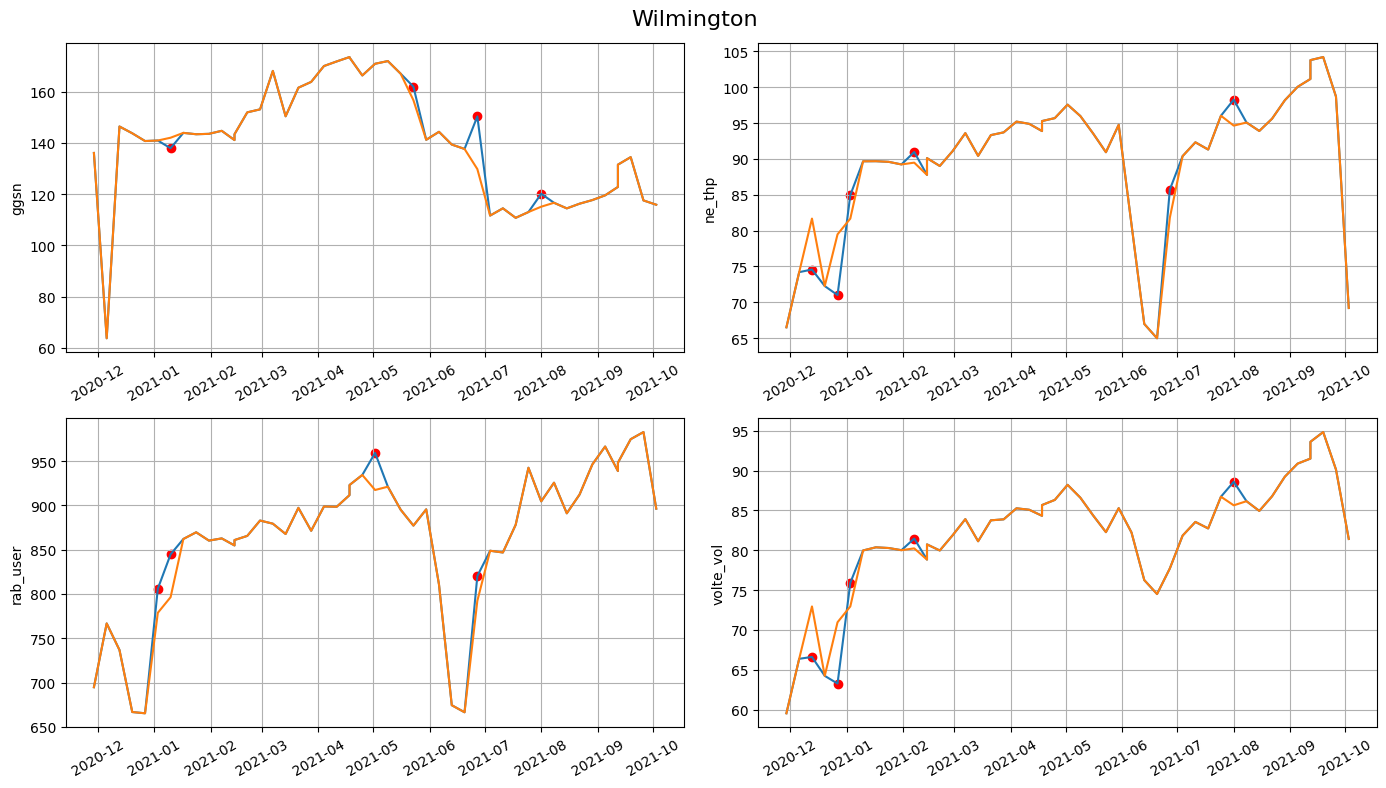

In [15]:
plt.figure(figsize=(14, 8))
for i, col in enumerate([col_ggsn, col_nethp, col_rabuser, col_volte]):
    ax = plt.subplot(2, 2, i + 1)
    ax.plot(dictdf_out[area][col_date], dictdf_out[area][col])
    cond = dictdf_out[area][f'{col}_outlier'] > 0.34
    ax.scatter(dictdf_out[area][col_date][cond], dictdf_out[area][col][cond], color='red')
    ax.plot(dictdf_outimp[area][col_date], dictdf_outimp[area][col])
    ax.set_ylabel(col)
    ax.tick_params('x', rotation=30)
    ax.grid()
plt.suptitle(area, fontsize=16)
plt.tight_layout()
plt.show()

## Outlier detection and imputation 2

In [16]:
dictdf_out2 = {}

threshold = 1.5
window_size = 10

for area in dictdf_outimp.keys():
    dictdf_out2[area] = dictdf_outimp[area].copy()
    for col in [col_ggsn, col_nethp, col_rabuser, col_volte]:

        z_scores = np.abs(stats.zscore(dictdf_out2[area][col]))
        
        outliers_index = dictdf_out2[area].index[z_scores > threshold]
        
        rolling_average = dictdf_out2[area][col].rolling(window=window_size, min_periods=1).mean()
        for idx in outliers_index:
            dictdf_out2[area].loc[idx, col] = rolling_average[idx]


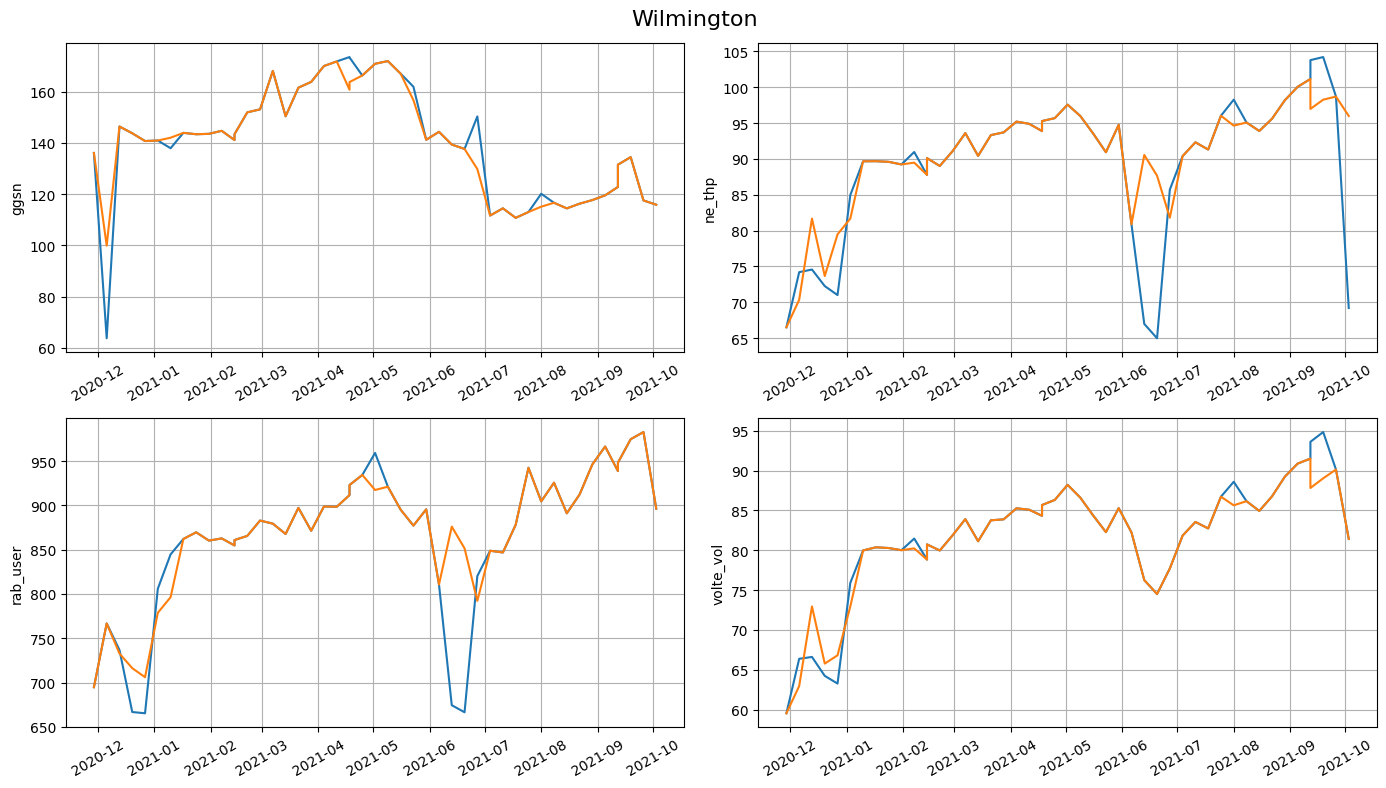

In [17]:
plt.figure(figsize=(14, 8))
for i, col in enumerate([col_ggsn, col_nethp, col_rabuser, col_volte]):
    ax = plt.subplot(2, 2, i + 1)
    ax.plot(dictdf_imp[area][col_date], dictdf_imp[area][col])

    ax.plot(dictdf_out2[area][col_date], dictdf_out2[area][col])
    ax.set_ylabel(col)
    ax.tick_params('x', rotation=30)
    ax.grid()
plt.suptitle(area, fontsize=16)
plt.tight_layout()
plt.show()

## Outlier detection and imputation 3

In [18]:
dictdf_out3 = {}

threshold = 1.5
window_size = 10

for area in dictdf_out2.keys():
    dictdf_out3[area] = dictdf_out2[area].copy()
    for col in [col_ggsn, col_nethp, col_rabuser, col_volte]:
        mydiff = dictdf_out3[area][col].diff().fillna(dictdf_out3[area][col].diff().min())
        z_scores = np.abs(stats.zscore(mydiff))
        
        outliers_index = dictdf_out3[area].index[z_scores > threshold]

        dictdf_out3[area].loc[outliers_index, col] = np.nan
        dictdf_out3[area][col] = dictdf_out3[area][col].ffill()
        dictdf_out3[area][col] = dictdf_out3[area][col].bfill()
        


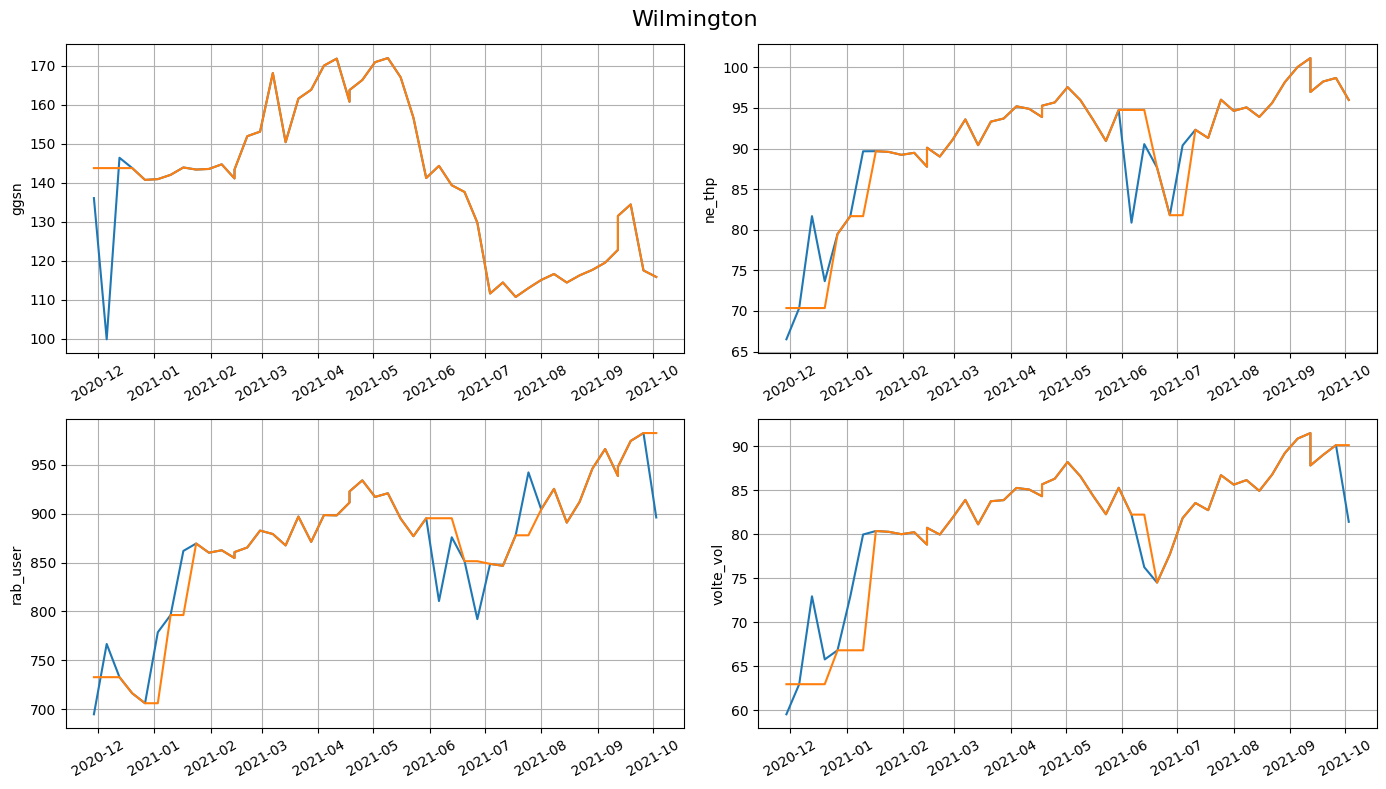

In [19]:
plt.figure(figsize=(14, 8))
for i, col in enumerate([col_ggsn, col_nethp, col_rabuser, col_volte]):
    ax = plt.subplot(2, 2, i + 1)
    ax.plot(dictdf_out2[area][col_date], dictdf_out2[area][col])

    ax.plot(dictdf_out3[area][col_date], dictdf_out3[area][col])
    ax.set_ylabel(col)
    ax.tick_params('x', rotation=30)
    ax.grid()
plt.suptitle(area, fontsize=16)
plt.tight_layout()
plt.show()

## Prepare prediction for test validation

In [54]:
dictdf_predval = {}
dictdf_test = {}

for area, dfgroup in dftest.groupby(col_area):
    dates_complete = pd.date_range(dfgroup[col_date].min(), dfgroup[col_date].max(), freq='W-Sun')
    dfdate = pd.DataFrame({
        col_date: dates_complete
    })

    dictdf_predval[area] = dfdate.copy()
    dictdf_test[area] = dfgroup.copy().reset_index(drop=True)

dictdf_predval[area].head()

,date
0,2021-10-10
1,2021-10-17
2,2021-10-24
3,2021-10-31
4,2021-11-07


# Method and model selection

## Univariate ARIMA model

In [55]:
for area in dictdf_out3.keys():
    model_arima = auto_arima(dictdf_out3[area][col_ggsn], start_p=0, start_q=0,
                       test='adf', # using adftest to search optimum 'd'
                       max_p=5, max_q=5,
                       m=1, # frequency
                       d=None, # the model will search
                       seasonal=False,
                       start_P=0,
                       D=0,
                       trace=False,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True
                      )
    dictdf_predval[area][f'{col_ggsn}_arima'] = model_arima.predict(dictdf_predval[area].shape[0]).values
    dictdf_test[area] = dictdf_test[area].merge(dictdf_predval[area][[col_date, f'{col_ggsn}_arima']], on=col_date, how='left')
    
dictdf_test[area].head()

,area,ne_thp,volte_vol,rab_user,ggsn,date,ggsn_arima
0,Wilmington,99.186104,91.287125,902.610378,82.064684,2021-12-19,108.612055
1,Wilmington,104.988188,94.699690,950.550756,83.428462,2021-12-12,109.270200
2,Wilmington,101.055286,91.662672,910.303175,86.578520,2021-12-05,109.928346
3,Wilmington,99.141527,90.028397,925.612891,121.527617,2021-11-28,110.586491
4,Wilmington,104.376532,94.494947,925.557607,125.102337,2021-11-21,111.244636


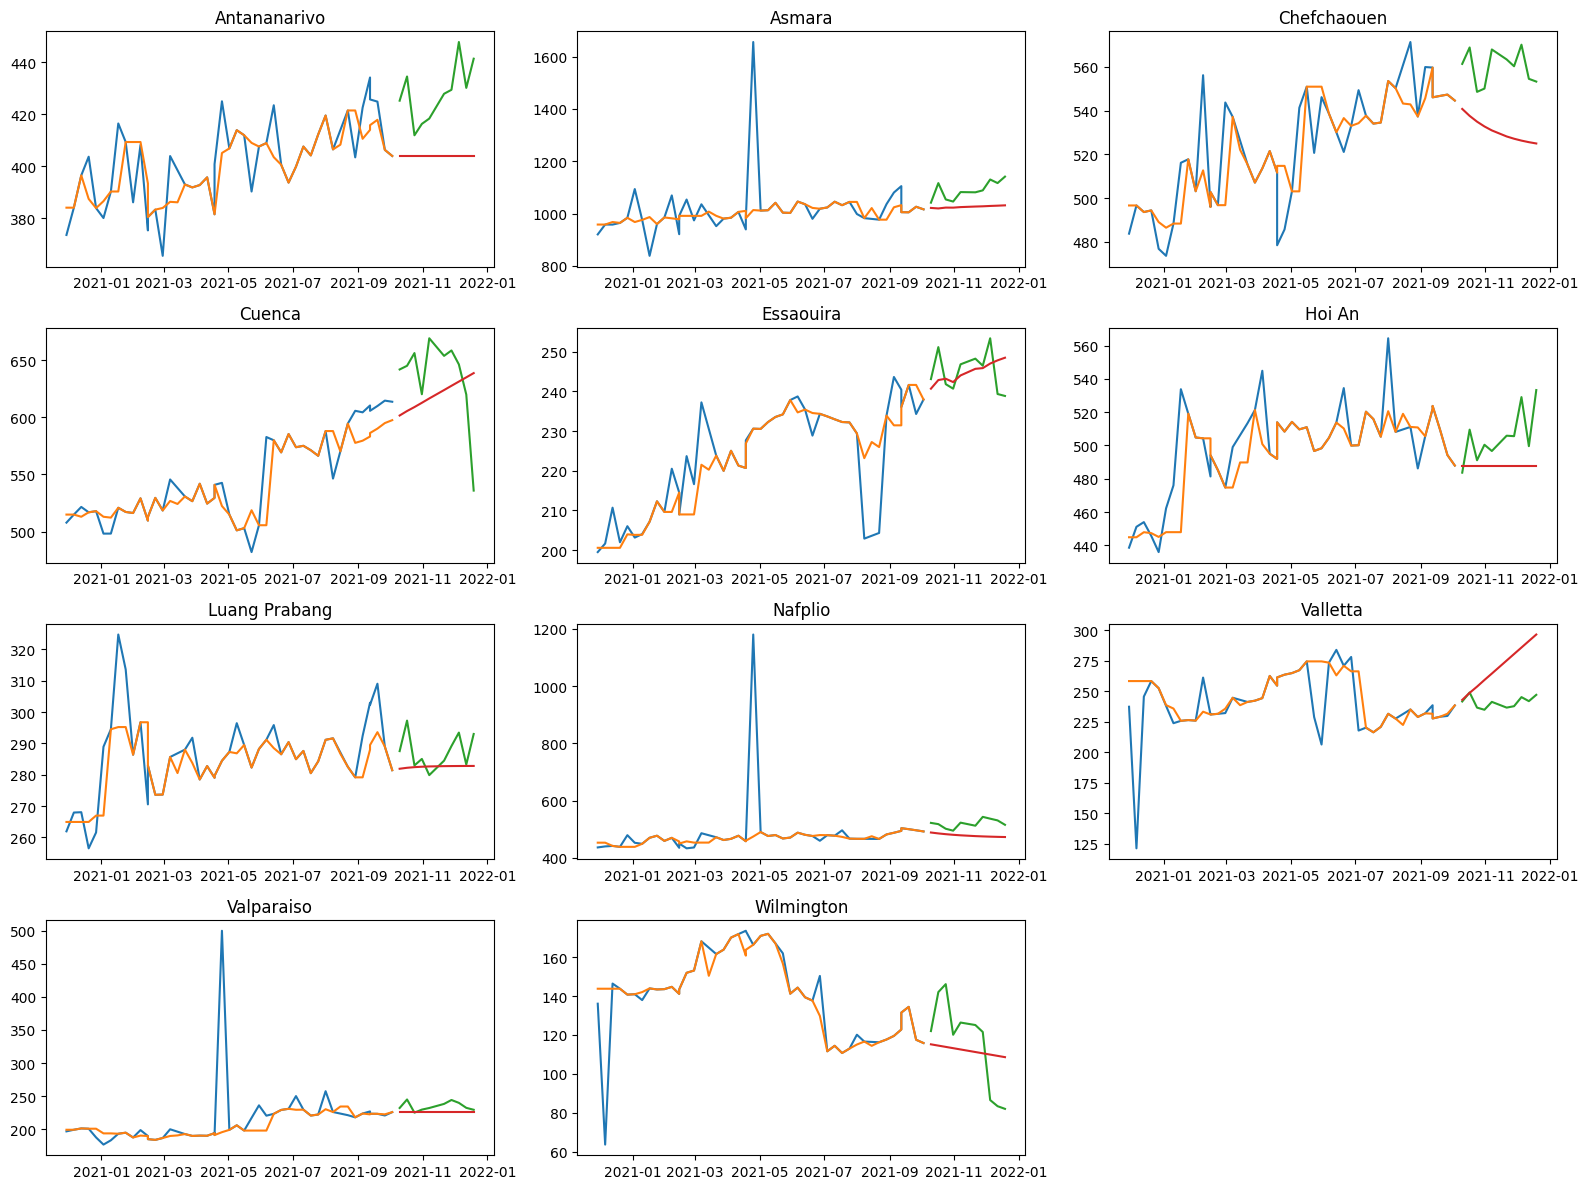

In [56]:
plt.figure(figsize=(16, 12))
for i, area in enumerate(dictdf_test.keys()):
    ax = plt.subplot(4, 3, i + 1)
    ax.plot(dictdf[area][col_date], dictdf[area][col_ggsn])
    ax.plot(dictdf_out3[area][col_date], dictdf_out3[area][col_ggsn])
    ax.plot(dictdf_test[area][col_date], dictdf_test[area][col_ggsn])
    ax.plot(dictdf_test[area][col_date], dictdf_test[area][f'{col_ggsn}_arima'])
    ax.set_title(area)
plt.tight_layout()
plt.show()

In [57]:
dfmape = []

for area in dictdf_test.keys():
    dfmape.append({
        'area': area,
        'mape_arima': mean_absolute_percentage_error(dictdf_test[area][col_ggsn], dictdf_test[area][f'{col_ggsn}_arima'])
    })     
dfmape = pd.DataFrame(dfmape).set_index('area')
dfmape

,mape_arima
area,
Antananarivo,0.056390
Asmara,0.057975
Chefchaouen,0.051498
Cuenca,0.061993
Essaouira,0.018056
Hoi An,0.035668
Luang Prabang,0.019170
Nafplio,0.078431
Valletta,0.119214


## Univariate ETS model

In [58]:
for area in dictdf_out3.keys():
    ets_mod = ETSModel(dictdf_out3[area][col_ggsn],
                      error="add",
                      trend='add',
                      seasonal=None,
                      seasonal_periods=None,
                      damped_trend=True,
                      # bounds=bounds
                      )

    ets_fit = ets_mod.fit(maxiter=10000, disp=0)
    
    # dictdf_out[col_ggsn] = ets_fit.fittedvalues
    
    dictdf_predval[area][f'{col_ggsn}_ets'] = ets_fit.forecast(steps=dictdf_predval[area].shape[0]).values
    dictdf_test[area] = dictdf_test[area].merge(dictdf_predval[area][[col_date, f'{col_ggsn}_ets']], on=col_date, how='left')

dictdf_test[area].head()

,area,ne_thp,volte_vol,rab_user,ggsn,date,ggsn_arima,ggsn_ets
0,Wilmington,99.186104,91.287125,902.610378,82.064684,2021-12-19,108.612055,113.300315
1,Wilmington,104.988188,94.699690,950.550756,83.428462,2021-12-12,109.270200,113.369941
2,Wilmington,101.055286,91.662672,910.303175,86.578520,2021-12-05,109.928346,113.456975
3,Wilmington,99.141527,90.028397,925.612891,121.527617,2021-11-28,110.586491,113.565766
4,Wilmington,104.376532,94.494947,925.557607,125.102337,2021-11-21,111.244636,113.701756


In [59]:
dfmape['mape_ets'] = np.nan
for area in dictdf_test.keys():
    dfmape.at[area, 'mape_ets'] = mean_absolute_percentage_error(dictdf_test[area][col_ggsn], dictdf_test[area][f'{col_ggsn}_ets'])
dfmape

,mape_arima,mape_ets
area,,
Antananarivo,0.056390,0.056364
Asmara,0.057975,0.065012
Chefchaouen,0.051498,0.014620
Cuenca,0.061993,0.075230
Essaouira,0.018056,0.020745
Hoi An,0.035668,0.028911
Luang Prabang,0.019170,0.019227
Nafplio,0.078431,0.045245
Valletta,0.119214,0.018025


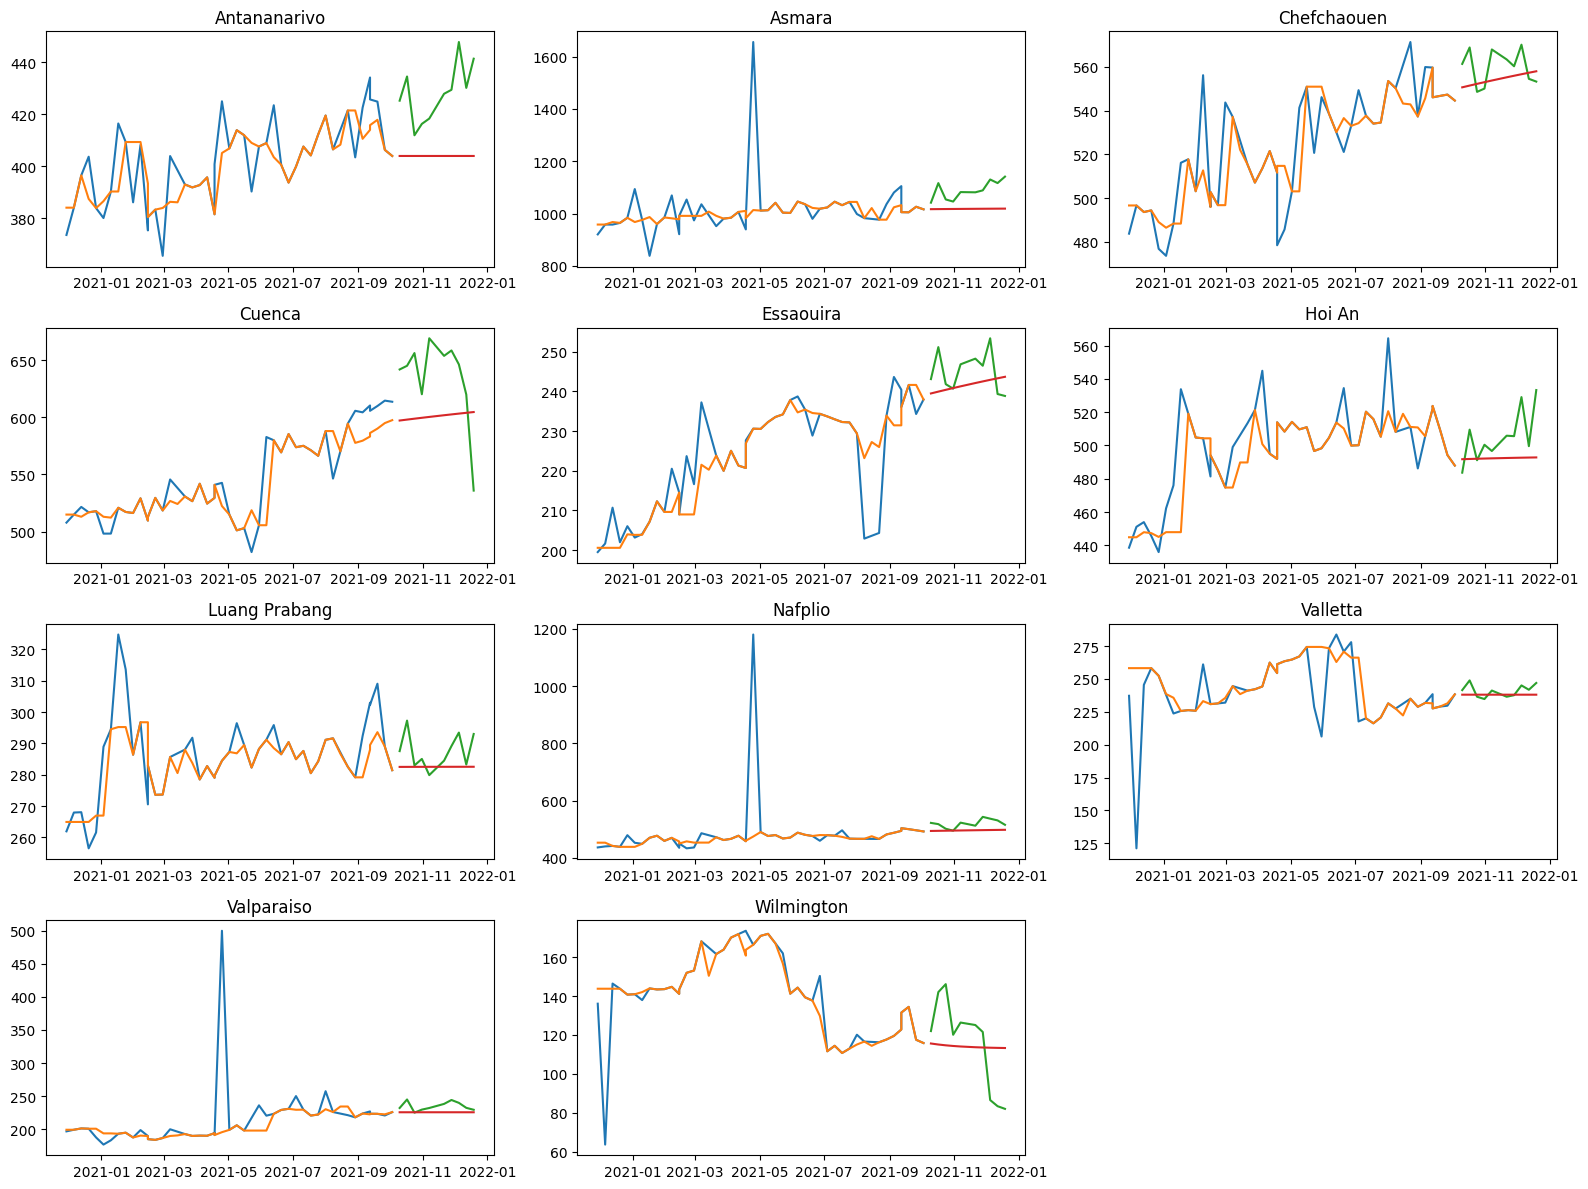

In [53]:
plt.figure(figsize=(16, 12))
for i, area in enumerate(dictdf_test.keys()):
    ax = plt.subplot(4, 3, i + 1)
    ax.plot(dictdf[area][col_date], dictdf[area][col_ggsn])
    ax.plot(dictdf_out3[area][col_date], dictdf_out3[area][col_ggsn])
    ax.plot(dictdf_test[area][col_date], dictdf_test[area][col_ggsn])
    ax.plot(dictdf_test[area][col_date], dictdf_test[area][f'{col_ggsn}_ets'])
    ax.set_title(area)
plt.tight_layout()
plt.show()

## 3 drivers ARIMA and OLS

## 3 drivers ETS and OLS

## ARIMA ratio model

## ETS ratio model

# Plot for display

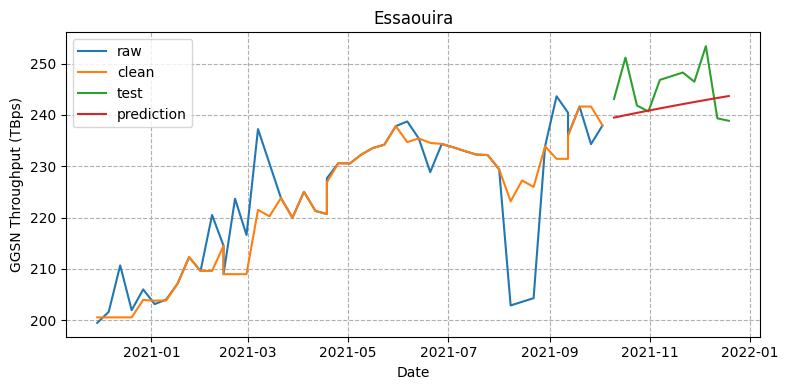

In [47]:
area = 'Essaouira'

plt.figure(figsize=(8, 4))
plt.plot(dictdf[area][col_date], dictdf[area][col_ggsn], label="raw")
plt.plot(dictdf_out3[area][col_date], dictdf_out3[area][col_ggsn], label="clean")
plt.plot(dictdf_test[area][col_date], dictdf_test[area][col_ggsn], label="test")
plt.plot(dictdf_test[area][col_date], dictdf_test[area][f'{col_ggsn}_val'], label="prediction")
plt.grid(linestyle='dashed')
plt.title(area)
plt.xlabel("Date")
plt.ylabel("GGSN Throughput (TBps)")
plt.legend() 
plt.tight_layout()
plt.savefig("result.png", dpi=300)
plt.show()